## 0. Libarary 불러오기 및 경로설정

In [1]:
# import 
import numpy as np
from PIL import Image
import json
from glob import glob
from pathlib import Path
import pandas as pd
import random

import os
import random
import matplotlib.pyplot as plt
from PIL import Image
import time
from datetime import timedelta
from collections import deque, defaultdict
import re 
import matplotlib.image as mpimg
from collections import OrderedDict
from math import *
import xml.etree.ElementTree as ET 
from tqdm import tqdm

# torch
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from torch.autograd import Variable

In [2]:
import numpy as np
print( np.__version__ )

1.20.3


In [3]:
BASE_DIR = '/opt/ml/input/data'
classes = ("UNKNOWN", "General trash", "Paper", "Paper pack", "Metal", "Glass", 
           "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing")

train_path = BASE_DIR + '/train.json'
with open(train_path, 'r') as f:
    lists = json.load(f)
    
images = {'image_id': {}, 'path': {}}
for i in classes:
    images[i] = {}
    
for i in range(len(lists['images'])):
    tmp = [ann['category_id'] for ann in lists['annotations'] if ann['image_id']==i]
    images['image_id'][i] = i
    images['path'][i] = lists['images'][i]['file_name']
    for j in range(len(classes)):
        if j in tmp:
            images[classes[j]][i] = True
        else:
            images[classes[j]][i] = False

train_df = pd.DataFrame(data = images)

In [4]:
train_df

,image_id,path,UNKNOWN,General trash,Paper,Paper pack,Metal,Glass,Plastic,Styrofoam,Plastic bag,Battery,Clothing
0,0,batch_01_vt/0003.jpg,False,True,False,False,False,False,False,False,True,False,False
1,1,batch_01_vt/0005.jpg,False,False,False,False,False,False,True,False,False,False,False
2,2,batch_01_vt/0006.jpg,False,False,False,False,True,False,True,False,False,False,False
3,3,batch_01_vt/0007.jpg,False,False,False,False,False,False,True,False,False,False,False
4,4,batch_01_vt/0010.jpg,False,True,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2612,2612,batch_03/0991.jpg,False,False,False,False,True,False,False,False,False,False,False
2613,2613,batch_03/0994.jpg,False,False,True,False,False,False,True,True,True,False,False
2614,2614,batch_03/0996.jpg,False,True,True,False,False,False,False,True,False,False,False
2615,2615,batch_03/0997.jpg,False,False,True,False,False,False,False,False,False,False,False


In [5]:
test_path = '/opt/ml/input/data/val.json'
with open(test_path, 'r') as f:
    lists = json.load(f)
    
images = {'image_id': {}, 'path': {}}
for i in classes:
    images[i] = {}
    
for i in range(len(lists['images'])):
    tmp = [ann['category_id'] for ann in lists['annotations'] if ann['image_id']==i]
    images['image_id'][i] = i
    images['path'][i] = lists['images'][i]['file_name']
    for j in range(len(classes)):
        if j in tmp:
            images[classes[j]][i] = True
        else:
            images[classes[j]][i] = False
    
test_df = pd.DataFrame(data = images)

In [6]:
test_df

,image_id,path,UNKNOWN,General trash,Paper,Paper pack,Metal,Glass,Plastic,Styrofoam,Plastic bag,Battery,Clothing
0,0,batch_01_vt/0002.jpg,False,False,False,False,False,True,True,False,True,False,False
1,1,batch_01_vt/0009.jpg,False,False,True,False,False,False,True,False,False,False,False
2,2,batch_01_vt/0018.jpg,True,True,False,False,False,False,False,False,True,False,False
3,3,batch_01_vt/0019.jpg,False,False,True,False,False,False,False,False,True,False,False
4,4,batch_01_vt/0030.jpg,False,False,False,True,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
650,650,batch_03/0981.jpg,False,True,False,False,False,False,False,False,True,False,False
651,651,batch_03/0982.jpg,False,False,True,False,False,False,False,False,False,False,False
652,652,batch_03/0988.jpg,False,True,False,True,True,False,True,False,False,False,False
653,653,batch_03/0993.jpg,False,True,True,False,False,False,False,False,False,False,False


## 1. Model 정의

In [7]:
import timm
model_names = timm.list_models(pretrained=True)

In [8]:
model = timm.create_model('tf_efficientnet_b4', pretrained=True)

model.classifier = nn.Linear(in_features=1792, out_features=11) # 모델마다 다르게
print(model)

EfficientNet(
  (conv_stem): Conv2dSame(3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (act1): SwishMe()
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
        (bn1): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SwishMe()
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
          (act1): SwishMe()
          (conv_expand): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
        )
        (conv_pw): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act2): Identity()
      )
      (1): DepthwiseSeparableConv(
        (conv_dw): Conv2d

## 학습 설정

In [9]:
class AttributeDict(dict):
    def __init__(self):
        self.__dict__ = self
        
class ConfigTree:
    def __init__(self):
        self.DATASET = AttributeDict()
        self.SYSTEM = AttributeDict()
        self.TRAIN = AttributeDict()
        self.MODEL = AttributeDict()
        self.KD = AttributeDict()
        self.SCHEDULER = AttributeDict()

class Trainer:
    def __init__(self, model, optimizer, cfg, device, train_loader, val_loader):
        self.cfg = cfg
        self.device = device
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.save_path = cfg.BASE_SAVE_DIR
        self.threshold = cfg.THRESHOLD
        self.num_classes = cfg.DATASET.NUM_CLASSES
        
        print("[INFO] using gpu {}".format(cfg.SYSTEM.GPU))

        self.model = model.to(device)
        
        update_params = [p for p in model.parameters() if p.requires_grad]
        if optimizer == 'SGD':
            self.optimizer = optimizer(update_params, lr=cfg.TRAIN.BASE_LR, weight_decay=cfg.TRAIN.WEIGHT_DECAY, momentum = cfg.TRAIN.MOMENTUM, nesterov = cfg.TRAIN.NESTEROV)
        else:
            self.optimizer = optimizer(update_params, lr=cfg.TRAIN.BASE_LR, weight_decay=cfg.TRAIN.WEIGHT_DECAY)
        self.criterion = nn.MultiLabelSoftMarginLoss()
        self.total_step = 0
        self.training_time = 0
        
        print(model)
        print()
        print(optimizer)
        print()
        
    def train_eval(self, name='model'):
        print("training start!\n")
        for epoch in range(self.cfg.TRAIN.EPOCH_CONTINUE, self.cfg.TRAIN.EPOCH):
            self.train_one_epoch(epoch)
            self.test_one_epoch(epoch)
            self.save_model(epoch,name)
    
    def train_one_epoch(self,epoch):
        print('\nEpoch: %d' % epoch)
        self.model.train()
        
        train_loss = 0
        correct = 0
        total = 0
        for batch_idx, (inputs, targets) in enumerate(self.train_loader):
            inputs, targets = Variable(inputs.to(self.device)), Variable(targets.to(self.device))
            outputs = self.model(inputs)
            outputs = torch.sigmoid(outputs)
            loss = self.criterion(outputs, targets)
            loss.backward()
            self.optimizer.step()

            train_loss += loss.item()
            total += targets.size(0)
            predicted = [outputs >= self.threshold]
            tmp = 0
            for p, t in zip(predicted[0], targets):
                tmp += torch.eq(torch.as_tensor(p, dtype = torch.long).to(self.device), t).sum().item()
            correct += tmp / self.num_classes
            
            if batch_idx % self.cfg.TRAIN.PERIOD ==0:
                print('Loss: %.3f | Acc: %.3f%% ' %(train_loss/(batch_idx+1),100.*correct/total))
        
    def test_one_epoch(self,epoch):
        self.model.eval()
        
        test_loss = 0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for batch_idx, (inputs, targets) in enumerate(self.val_loader):
                inputs, targets = Variable(inputs.to(self.device)), Variable(targets.to(self.device))
                outputs = self.model(inputs)
                outputs = torch.sigmoid(outputs)
                loss = self.criterion(outputs, targets)

                test_loss += loss.item()
                total += targets.size(0)
                predicted = [outputs >= self.threshold]
                tmp = 0
                for p, t in zip(predicted[0], targets):
                    tmp += torch.eq(torch.as_tensor(p, dtype = torch.long).to(self.device), t).sum().item()
                correct += tmp / self.num_classes
                
        print(f'Accuracy of the network on the {total} test images: %d %%' % (
        100 * correct / total))
        
    
    def save_model(self, epoch, name='model'):
        print('saved model {}'.format(self.save_path)) 
        if not os.path.exists(self.save_path):
            os.mkdir(self.save_path)
        file_name = '{}_{}.pth'.format(name, epoch)
        file_path = os.path.join(self.save_path, file_name)
        torch.save(self.model.state_dict(), file_path)
            
        return None      

## 2. Test Dataset 정의

In [10]:
class P3_Dataset(Dataset):
    def __init__(self, dataframe, root_dir, transform = None):
        self.annotations = dataframe
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.annotations)
        
    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[idx, 1])
        image = Image.open(img_path)
        label = []
        for i in range(2,13):
            label.append(self.annotations.iloc[idx,i])
        
        if self.transform:
            image = self.transform(image)
        
        label = torch.Tensor(label)
        label = torch.as_tensor(label, dtype = torch.long)
        return image, label

#### Data augmentation 함수

In [11]:
def get_augmentation(size= (224,224), use_flip=True, use_color_jitter=True):
    resize_crop = transforms.Resize(size= size)
    random_h_flip = transforms.RandomHorizontalFlip(p=0.5)
    random_v_flip = transforms.RandomVerticalFlip(p=0.5)
    color_jitter = transforms.RandomApply([
        transforms.ColorJitter(0.5, 0.5, 0.5, (-0.2,0.2))
    ], p=0.8)
    random_affine = transforms.RandomAffine(0, shear = [-10,10,-10,10])
    
    gray_scale = transforms.RandomGrayscale(p=0.2)
    normalize = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    to_tensor = transforms.ToTensor()
    
    transforms_array = np.array([resize_crop, random_h_flip, random_v_flip, color_jitter, random_affine,  gray_scale, to_tensor, normalize])
    transforms_mask = np.array([True, use_flip, use_flip, use_color_jitter, True, True, True, True])
    
    transform = transforms.Compose(transforms_array[transforms_mask])
                     
    return transform

### Config 설정

In [12]:
config = ConfigTree()
config.SYSTEM.GPU = 0 # GPU 번호 
config.BASE_SAVE_DIR = 'output' # 모델 파라미터가 저장되는 위치

config.DATASET.ROOT = "./train" # 데이터 위치
config.DATASET.NUM_CLASSES = 11 # 분류해야 하는 클래스 종류의 수 
config.DATASET.RATIO = 0.15 # train, test split 비율 

# 사용할 augmentation
config.TRAIN.AUGMENTATION = {'size' : (380,380),
                             'use_flip' : True,
                             'use_color_jitter' : True,
} 
config.TRAIN.WEIGHT_DECAY = 1e-2
config.TRAIN.EPOCH = 100 # 총 학습 에폭 
config.TRAIN.BATCH_SIZE = 32 # 배치 사이즈 
config.TRAIN.BASE_LR = 3e-5 # 러닝 레이트 
config.TRAIN.PERIOD = 10 # loss 측정 주기
config.TRAIN.MOMENTUM = 0.9 # for SGD and MADGRAD
config.TRAIN.NESTEROV = False # for SGD and AdamP
config.MODEL.OPTIM = 'Adam' # 'SGD, Adam, rmsprop etc...'
config.TRAIN.EPOCH_CONTINUE = 0 # 이어서 학습 하는 경우 맨 마지막 모델 epoch + 1로 설정.
config.THRESHOLD = 0.5 # confidence, (for each label)

config.TRAIN.MODEL = model

## SEED 설정

In [13]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

seed_everything(42)

## 사진 아무거나 띄워보기

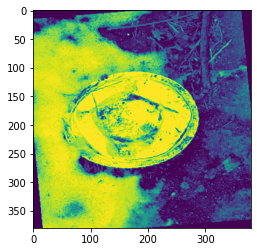

In [14]:
transform = get_augmentation(**config.TRAIN.AUGMENTATION)
dataset = P3_Dataset(dataframe = train_df, root_dir = BASE_DIR, transform = transform)

plt.imshow(dataset[random.randint(0, len(dataset))][0].numpy()[0])

In [15]:
def main(config):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    transform = get_augmentation(**config.TRAIN.AUGMENTATION)
    dataset = P3_Dataset(dataframe = train_df, root_dir = BASE_DIR, transform = transform)
    len_valid_set = int(config.DATASET.RATIO*len(dataset))
    len_train_set = len(dataset) - len_valid_set

    print("The length of Train set is {}".format(len_train_set))
    print("The length of Valid set is {}".format(len_valid_set))

    train_dataset , valid_dataset = torch.utils.data.random_split(dataset ,
                                                                  [len_train_set, len_valid_set])

    # shuffle and batch the datasets
    train_loader = torch.utils.data.DataLoader(dataset,
                                            batch_size=config.TRAIN.BATCH_SIZE,
                                            shuffle=True) 
    valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                            batch_size=config.TRAIN.BATCH_SIZE,
                                            shuffle=False)

    # define model(student)
    model = config.TRAIN.MODEL
    #model.load_state_dict(torch.load("output/model_14.pth")) # 저장된거 불러오기
    optimizer = optim.__dict__[config.MODEL.OPTIM]

    # fitting ... 
    trainer = Trainer(model, optimizer, config, device,
                    train_loader, train_loader)
    trainer.train_eval()

In [16]:
torch.cuda.empty_cache()

import gc
gc.collect()

44

In [17]:
torch.cuda.is_available()

True

In [ ]:
main(config)

The length of Train set is 2225
The length of Valid set is 392
[INFO] using gpu 0
EfficientNet(
  (conv_stem): Conv2dSame(3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (act1): SwishMe()
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
        (bn1): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SwishMe()
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
          (act1): SwishMe()
          (conv_expand): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
        )
        (conv_pw): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act2

## 3. Test Dataset 정의

In [19]:
class P3_TestDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform = None):
        self.annotations = dataframe
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.annotations)
        
    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[idx, 1])
        image = Image.open(img_path)
        label = []
        for i in range(2,13):
            label.append(self.annotations.iloc[idx,i])
        
        if self.transform:
            image = self.transform(image)
        
        label = torch.Tensor(label)
        label = torch.as_tensor(label, dtype = torch.long)
        return image, label

## 4. Inference + best epoch 찾기

In [ ]:
test_transform = transforms.Compose([
        transforms.Resize((380,380)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

test_dataset = P3_TestDataset(dataframe = test_df, root_dir = '/opt/ml/input/data/' , transform = test_transform)

test_loader = DataLoader(
    test_dataset,
    shuffle=False
)

best = 0; best_epoch = 0;
for i in range(9): # epoch 0 ~ 8 까지 성능 확인해보기.
# 모델 정의
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    result_path = 'output/model_'+str(i)+'.pth'
    model.load_state_dict(torch.load(result_path,map_location='cuda:0'), strict=False)
    model.eval()
    model.cuda()

    acc = 0
    for images, labels in tqdm(test_loader):
        with torch.no_grad():
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            outputs = torch.sigmoid(outputs)
            pred = [outputs >= config.THRESHOLD]
            pred_acc = pred[0].eq(labels).sum().item()
            acc += pred_acc/config.DATASET.NUM_CLASSES

    cur = acc / len(test_dataset)
    print(f'epoch : {i}, accuracy: {cur}')
    if (best < cur):
        best = cur
        best_epoch = i
        print(f'current best accuracy: {best}')
          
print(f'best_epoch :{best_epoch}')
print('test inference is done!')

  0%|          | 0/655 [00:00<?, ?it/s]

epoch : 0, accuracy: 0.8247050659264441
current best accuracy: 0.8247050659264441


  0%|          | 0/655 [00:00<?, ?it/s]

epoch : 1, accuracy: 0.8507980569049313
current best accuracy: 0.8507980569049313


  0%|          | 0/655 [00:00<?, ?it/s]

epoch : 2, accuracy: 0.8488549618320649


  0%|          | 0/655 [00:00<?, ?it/s]

epoch : 3, accuracy: 0.8419153365718294


  0%|          | 0/655 [00:00<?, ?it/s]

epoch : 4, accuracy: 0.8491325468424743


  0%|          | 0/655 [00:00<?, ?it/s]

epoch : 5, accuracy: 0.8523247744621825
current best accuracy: 0.8523247744621825


 48%|████▊     | 315/655 [00:10<00:11, 29.62it/s]